### Importing Libraries

**The libraries that are used in the project are provided below:**
* __Numpy__: *for the Python programming language, adding support for large, multi-dimensional arrays and matrices,along with a large collection of high-level mathematical functions to operate on these arrays.*
* __Pandas__: *for the Python programming language for data manipulation and analysis.*
* __Time__: *To calculate accurate CPU time when algorithm is running.*
* __Math__: *To compute mathematical formulations, like distance.*
* __Random__: *To earn random data.*
* __Matplotlib__: *To figure out and visualize locations, the algorithm's trend, and routes that have been created by the algorithm.* 

In [1]:
import numpy as np
import pandas as pd
from math import degrees, atan2, sqrt
import time
import math
from random import randint
import random
import matplotlib.pyplot as plt

### Functions
#### In this part, we declare the functions that are been used for PSO Algorithm.**
**They functioned for:**
* **dataset_info():**       _Reading MetaData_
* **get_files():**          _preparing to assign data to pandas DataFrame_
* **get_table():**          _Creating dataframe with locations and demand_
* **coordinates():**        _Return coordinates of all clients' location_
* **comput_cost():**        _To Calculate cost of each Route, (Objective function)_
* **active_graph():**       _To figure out acive arcs in network for each Route_
* **get_data_information():** _To get instance information's parameters_
* **calculateDepotAngle():** _To calculate angles of each point from depot for using in sweep algorithm_
* **get_route():** _To create feasible route with each ordered list of clients_
* **Clients_Angles():** _It's Lists the angles that are calculated_
* **Creating_Particles():** _To create list of clients respect to clients' angles_ 
* **Route_byItscost():** _Caculates cost of each route and returns routes with their lossfuntion value_
* **UpD_Gbest():** _To update the best solution found by the entire neighborhood (gbest )_
* **UpD_Pbest():** _To update the value found by a particular particle (pbest )_
* **Initial_velocity():** _To initial random number between -4 and +4 respect to uniform distribution_
* **sigmoid():** _To map velocity's value on 0 and 1_
* **Update_velocity():** _To update velocity in each iteration by previous its value and Gbest and Pbest_
* **Updat_particles():** _Udates position of each particle_
* **new_particlesPosition():** _To update location of each particle_
* **Sweep_Algorithm():** _A greedy algorithm to Initial solution_
* **active_Route():** _For each sub route returns active arcs_
* **two_opt():** _A method for optimizing sub routes_
* **OPT_Route():** _To Optimize Routes_
* **Best_TSP():** _Returns the best sequence of clients in each route_

In [96]:
def dataset_info():
    '''this function reads the information about all datas
       and returns informations as a pandas table BKS'''
    
    #readin excel format file with pandas
    BKS =  pd.read_excel('BKS.xlsx', sheet_name='BKS')
    
    #rename the features
    BKS.rename(columns={'Ins':'file_name', 'n':'Nom_of_node', 'K':'K_min', 'Q':'veh_cap'}, inplace=True)
    
    # Add '.txt' to file_name values
    for i in range(30):
        BKS.loc[i,'file_name'] = BKS.loc[i,'file_name']+str('.txt')

    #Manually
    
#     file_name = 'X-n101-k25.txt'
#     Nom_of_node = 100
#     K_min = 25
#     veh_cap = 206
#     UB = 27591
#     My_dic = {'file_name': file_name, 'Nom_of_node':Nom_of_node , 'K_min': K_min,'veh_cap': veh_cap, 'UB':UB}
#     BKS = pd.DataFrame(My_dic, index = list(range(1)))
    return BKS

#================================ reading all text files ========================================================

def get_files(info):
    ''' This function reads all text files and pass them to a dictionary'''
    
    # Reading each file.txt as a table an save all them in a dictionary
    File_Name_dic = {}
    rows= info.index.tolist()
    for row in rows:
        File_Name_dic['data'+str(row)] = pd.read_table(info.loc[row, 'file_name'])
    return rows, File_Name_dic

# ======================== Extracting Tables from each File ====================================================

def get_table(BKS, File_Name_dic,rows):
    ''' Extracts tables from text files and saves them as dictionaries'''
    
    Locations={}
    Demands = {}
    
    # defining some parameters for slicing 
    L_N = 6+BKS['Nom_of_node']
    D_N_L = L_N+2
    D_N_U = D_N_L + BKS['Nom_of_node']
    
    # reading cotumers' location and costumers' demand from each file
    for row in rows:
        Locations['loc'+str(row)] = File_Name_dic['data'+str(row)].loc[6:L_N[row]]
        col2 = str(Locations['loc'+str(row)].columns[1])
        Locations['loc'+str(row)].rename(columns={'NAME : ':'ind',col2:'x','Unnamed: 2':'y'}, inplace=True)
        Locations['loc'+str(row)].set_index('ind', inplace=True)
    
        Demands['dem'+str(row)] = File_Name_dic['data'+str(row)].loc[D_N_L[row]:D_N_U[row]]
        Demands['dem'+str(row)].rename(columns={'NAME : ':'ind',col2:'d'}, inplace=True)
        Demands['dem'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)].drop('Unnamed: 2',axis=1, inplace=True)
    return Locations, Demands

def coordinates(df, BKS):
    '''return coordinates all points'''
    depo = df.iloc[0,:]
    x_d, y_d = depo[0], depo[1]
    x_c, y_c = df['x'][1:], df['y'][1:]
    return x_d, y_d, x_c, y_c

def comput_cost(D, active):
    '''to compute objective or loss function'''
    Total_cost = 0
    for i,j in active:
        Total_cost +=D[i,j]
    return Total_cost

def active_graph(Rout, cr):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}  #Binary variable is 1 if vehicle visits client j after visiting client i 
    for key in Rout.keys():
        for i in range(len(Rout[key])):
            if Rout[key][i] == Rout[key][-1]:
                j=0
            else: j = Rout[key][i+1]
            Y[Rout[key][i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs, Y

def get_data_information(Instance):
    instance = Instance-1
    data_information = dataset_info()
    rows, Files_name = get_files(data_information)
    Locations, Demands = get_table(data_information, Files_name, rows)
    df = Locations['loc'+str(instance)].astype(float)
    num_of_customer = data_information.loc[instance,'Nom_of_node']
    customer_list = [float(i) for i in range(1,num_of_customer+1 )]
    if instance == 8:gh=1
    else: gh=1
    all_nodes = [i for i in range(num_of_customer+1)]
    coords = [(i,j) for i in all_nodes for j in all_nodes if i!=j]
    distance = {(i,j): round(math.dist((df['x'][i],df['y'][i]), (df['x'][j],df['y'][j]))*gh) for i,j in coords}
    f_star = data_information.loc[instance, 'UB']
    demand = Demands['dem'+str(instance)]['d'].astype(float)           
    capacity = data_information.loc[instance,'veh_cap']
    K_min = data_information.loc[instance,'K_min']

    parameters = {'data_information':data_information,
                  'location':df,
                  'distance':distance,
                  'num_of_customer':num_of_customer,
                  'customer_list': customer_list,
                  'all_nodes': all_nodes,
                  'coords': coords,
                  'distance': distance,
                  'f_star':f_star,
                  'demand': demand,
                  'capacity': capacity,
                  'K_min': K_min}
    return parameters


def calculateDepotAngle(x,y,depot_x,depot_y):
    angle = degrees(atan2(y - depot_y, x - depot_x))
    bearing = (90 - angle) % 360
    return bearing


def get_route(client_priority,n, d, Q ):
    cp =list(map(int,client_priority))
    Initial_Route = {}   
    is_visited = [False for i in range(n)]
    j=0
    # for each customer checks the capacity feasibility of a route and assigns it
    while sum(is_visited)!=n:
        u = 0
        Initial_Route[j] = [0]
        for i in cp :
            if is_visited[i-1]==False:
                if u+d[i] <= Q:
                    Initial_Route[j].append(i)
                    is_visited[i-1]=True
                    u = u+d[i]
        j+=1
    return Initial_Route

def Clients_Angles(data_par):
    df = data_par['location']
    d_info = data_par['data_information']
    x_d, y_d, x_c, y_c = coordinates(df, d_info)
    angles =[]
    for i in range(len(x_c)):
        angles.append(calculateDepotAngle(x_c[i],y_c[i],x_d,y_d))
    return angles

def Creating_Particles(N,angles,Co_list):
    particles = []
    angles = np.asanyarray(angles)
    k = []
    K = 0
    k.append(K)
    for j in range(N):
        ANGLE=[]

        while K in k :
            K = random.sample(list(angles),1)[0]
        k.append(K)
        Angle = angles-K
        for j in list(Angle):
            if j<0:
                j+=360
            ANGLE.append(j)
        a = [float(x) for _,x in sorted(zip(ANGLE,Co_list))]
        a = np.asanyarray(a)
        b = np.random.uniform(low=1, high=Dimention_size, size=a.size)
        temp = np.stack((a, b), axis=1)
        particles.append(temp)
    particles = np.asanyarray(particles)
    return particles

def Route_byItscost(N,data_par, particle):
    Routes = {}
    Route = {}
    n   = data_par['num_of_customer']
    d   = data_par['demand']
    Q   = data_par['capacity']
    cr  = data_par['coords']
    dis = data_par['distance']
    for i in range(N):
        route = get_route(list(particle[i:i+1,:,0][0]),n,d,Q)
        Route[i] = route
        
    for i in Route.keys():
        active, xx = active_graph(Route[i], cr)
        cost = comput_cost(dis, active)
        Routes [cost] = Route[i]
    return Routes

def UpD_Gbest(routes, particles,bestsofar,g_best):
    cost_list = list(routes.keys())
    t1 = min(cost_list)
    if t1<bestsofar:
        t2 = cost_list.index(t1)
        gbest = particles[t2, :, 1].reshape(1,len(particles[t2, :, 1]))
    else: gbest = g_best
    return gbest


def UpD_Pbest(routes, Z_pbest, pbest, particles,best_Route):
    for i,j in enumerate(routes.keys()):
        if j<Z_pbest[i]:
            Z_pbest[i]=j
            pbest[i] = particles[i, :, 1]
            best_Route = routes[j]
    return Z_pbest, pbest, best_Route

def Initial_velocity(N, data_par):
    n = data_par['num_of_customer']
    velocity = np.random.uniform(low=-4, high=4, size = (N,n))
    return velocity

def sigmoid(x,w):
    sig = w / (1 + np.exp(-x))
    return sig


def Update_velocity(Param, V, pbest, gbest, particles):
    omega, phi1, = Param['Omega'], Param['Phi1']
    phi2 =                 Param['Phi2']
    beta1 = np.random.uniform()
    beta2 = np.random.uniform()
    Vel = omega*V + phi1*beta1*(pbest - particles[:,:,1]) + phi2*beta2*(gbest - particles[:,:,1])
    return Vel

def Updat_particles(V,n,Param):
    X = []
    N = len(V[:,0])
    sigma = Param['Sigma']
    beta = np.random.uniform(size = (N,n))
    X = np.round(V + (n-1)*sigma*beta)
    return X



def new_particlesPosition(V, N, particles):
    max_vel = np.max(V)
    vel_to_add = V/(2*max_vel)
    for par in range(N):
        b1=list(set(particles[:,:,1][par]))
        b2=[]
        for item in b1:
            b2.append([i for i, x in enumerate(particles[:,:,1][par]) if x == item])

        for i in range(len(b2)):
            if len(b2[i])>1:
                for j in b2[i]:
                    particles[:,:,1][par][j] = particles[:,:,1][par][j]+vel_to_add[par][j]

    for i in range(particles.shape[0]):
        particles[i,:,0] = [x for _,x in sorted(zip(particles[i,:,1],particles[i,:,0]))]
    particles[:,:,1] = np.sort(particles[:,:,1], axis=1)
    n = len(particles[0, :, 1])
    for j in range(N):
        for i,k in enumerate(particles[:,:,1][j]):
            if k>n-1:
                particles[:,:,1][j][i] = n-1
            elif k<0:
                particles[:,:,1][j][i] = 0
    return particles

def Sweep_Algorithm(param,N):
    Costumer_List = param['customer_list']
    Angles = Clients_Angles(param)
    Init_Prticles = Creating_Particles(N,Angles,Costumer_List)
    return Init_Prticles

def active_Route(Rout, cr):
    ''' Gets route and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}
    for i in range(len(Rout)):
        if Rout[i] == Rout[-1]:
            j=0
        else: j = Rout[i+1]
        Y[Rout[i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs

def Greedy(n,dist):
    H = [l for l in range(n+1)]
    M = [m for m in range(1,n+1)]
    coord_h = [(s,w) for s in H for w in H if s!=w]
    Y = {(m,n):dist[(m,n)] for m,n in coord_h}
    neithbor=[]
    all_checked = [False for c in range(n)]
    
    node_visited_init = []
    r = random.sample(M, round(n/10))
    for u in r:
        
        neithbor.append(u)
        node_visited_init.append(u)
        all_checked[u-1] = True

    while sum(all_checked)!= n:
        a = neithbor[-1]
        my_list = {}
        for b in H:
            if b not in node_visited_init:
                if b!=a:
                    my_list[b]=Y[(a,b)]
        my_list_as = {k: v for k, v in sorted(my_list.items(), key=lambda item: item[1])}
        my_list_key = list(my_list_as.keys())
        index = 0
        node_ass = False
        while node_ass == False and index<=1:
            visit = my_list_key[index]
            if all_checked[visit-1]==False:
                neithbor.append(visit)
                all_checked[visit-1]=True
                a = visit
                node_visited_init.append(visit)
                node_ass = True
                break
            index+=1
            if index >=len(my_list_key):
                    break
        node_not_visited = [e for e in range(1,n+1) if e not in node_visited_init]
        try:
            
            if index>1:
                r = random.sample(node_not_visited,1)[0]
                neithbor.append(r)
                node_visited_init.append(r)
                all_checked[r-1] = True
        except: ValueError
    return neithbor

def two_opt(route,param):
    cost = {}
    D = param['distance']
    cr = param['coords']
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)):
                if j-i == 1: continue # changes nothing, skip then
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                active = active_Route(new_route, cr)
                cost['new_route'] = comput_cost(D, active)
                active = active_Route(best, cr)
                cost['best'] = comput_cost(D, active)
                if cost['new_route'] < cost['best']:
                    best = new_route
                    improved = True
        route = best
    return best

def OPT_Route(routes,D_Par,method):
    costList = routes.keys()
    OPT_Routes = {}
    D = D_Par['distance']
    cr = D_Par['coords']
    for i in costList:
        R = routes[i]
        if method == '2_opt':
            L = len(R.keys())
            for j in range(L):
                rr = R[j]
                routes[i][j] = two_opt(rr, D_Par)
            actice1,xx = active_graph(routes[i], cr)
            cost_2_OP = comput_cost(D, actice1)
            OPT_Routes[cost_2_OP] = routes[i]
        else:
            temp = Best_TSP(routes[i], D)
            active2,xx = active_graph(temp, cr)
            Tsp_cost = comput_cost(D, active2)
            OPT_Routes[Tsp_cost] = temp
    return OPT_Routes

def Best_TSP(Rout, distance):
    Min_dis = {}
    testing = Rout.copy()
    for rout in testing.keys():
        coord = [(i,j) for i in testing[rout] for j in Rout[rout] if i!=j]
        Z = {(i,j):distance[(i,j)] for i,j in coord}
#         Z = dict(sorted(Z.items(), key=lambda item:item[1]))
        node_of_rout = testing[rout]
        node_visited = [0]
        for k in node_of_rout:
            min_dis = 10000
            for w in testing[rout]:
                if w!=k:
                    if w not in node_visited:
                        if Z[(k,w)] < min_dis:
                            min_dis = Z[(k,w)]
                            II = k
                            JJ = w
                            visited = w
            node_visited.append(visited)
            node_visited =list(dict.fromkeys(node_visited))
        Min_dis.update({rout:node_visited})
    return Min_dis

def local_search(routes, parameters):
    n = parameters['num_of_customer']
    dist = parameters['distance']
    for i in range(routes.shape[0]):
        routes[i] = Greedy(n,dist)
    return routes
def Initial_random(N, Co_list):
    particles = []
    random_list = [float(x) for x in range(len(Co_list))]
    for j in range(N):
        random.shuffle(random_list)
        a = [float(x) for _,x in sorted(zip(random_list,Co_list))]
        a = np.asanyarray(a)
        b = np.random.uniform(low=1, high=Dimention_size, size=a.size)
        temp = np.stack((a, b), axis=1)
        particles.append(temp)
    particles = np.asanyarray(particles)
    return particles

### PSO Algorithm


__Step 1:__ **Initialization**
* The number of particles i, dimension size d, and the number of iterations t_max are set.
* Parameter setting: The parameters are set along with the maximum, minimum, and step size of inertial weight.
* Initial particles Xid are determined using sweep algorithm.
* The initial velocity Vid of particles is randomly generated.

In [97]:
# Importing Instance and reading its parameters
Instance = 1
Data_Parameters = get_data_information(Instance=Instance)



# Initial Model Parameters
N_Particles = 5
Dimention_size = Data_Parameters['num_of_customer'] 
T_max = 1000
#Initial some PSO's parameters 
Pbest = np.ones((N_Particles, Dimention_size))
Gbest = np.ones((1, Dimention_size))
Z_Pbest = np.ones(N_Particles)*np.inf
Init_Velocity=Initial_velocity(N_Particles, Data_Parameters)
Beta = np.random.uniform(size = (N_Particles,Dimention_size))
B_route = {}
Vel_Up_Param = {'Omega':    0.7,  #is inertia weight that inﬂuences the velocity of the particle.
              
                'Phi1':     1,  #phi1 and phi2 are positive acceleration constants that control
                'Phi2':     2,  #the inﬂuences of pbest and gbest on the search process
              
                'Sigma':    0.5*Dimention_size,  #standard deviation sigma, and a random number beta ensures the 
                'BETA':    Beta,  #values to be between 0 and n-1.
             }


### Initial Solution and values
* **__In this part we create initial solution by SWEEP Algorithm__**

In [98]:
Particles = Sweep_Algorithm(Data_Parameters, N_Particles)
# C_L= Data_Parameters['customer_list']
# Particles = Initial_random(N_Particles, C_L)
Particles.shape

(5, 100, 2)

* **Calculating Gbest and Pbest respect to Initial solution**

In [99]:
ROUTES = Route_byItscost(N_Particles, Data_Parameters, Particles)

Z_Pbest, Pbest, BEST_ROUTE= UpD_Pbest(ROUTES, Z_Pbest, Pbest, Particles,B_route)
best_so_far = min(Z_Pbest)
Gbest = UpD_Gbest(ROUTES, Particles,best_so_far,Gbest)

### PSO Algorithm Model

In [100]:
Velocity = sigmoid(Init_Velocity,Dimention_size)
Loss = []
tic = time.time()

# CPU_TIME = 0
# while CPU_TIME<5:

for iteration in range(T_max):
    
    Loss.append(best_so_far)
    Velocity = Update_velocity(Vel_Up_Param,Velocity,Pbest,Gbest,Particles)
    Velocity = sigmoid(Velocity,Dimention_size)
    Particles[:,:,1] = Updat_particles(Velocity, Dimention_size,Vel_Up_Param)
    Particles= new_particlesPosition(Velocity, N_Particles, Particles)
#     Particles[:,:,0] = local_search(Particles[:,:,0], Data_Parameters)
    
    ROUTES = Route_byItscost(N_Particles, Data_Parameters, Particles)
#     if iteration > T_max//1.5:
#     ROUTES = OPT_Route(ROUTES,Data_Parameters, method = 'tsp')          #we choose how to improve routes tsp or 2_opt
    
    Z_Pbest, Pbest,BEST_ROUTE = UpD_Pbest(ROUTES, Z_Pbest, Pbest, Particles,BEST_ROUTE)
    best_so_far = min(Z_Pbest)
    
    Gbest = UpD_Gbest(ROUTES, Particles,best_so_far,Gbest)
    
    print('iteration is:', iteration, 'best so far:', Loss[-1])
    toc = time.time()
    CPU_TIME = round((toc-tic)/60,2)
Best_Objective_function = Loss[-1]

iteration is: 0 best so far: 40403.0
iteration is: 1 best so far: 40403.0
iteration is: 2 best so far: 40403.0
iteration is: 3 best so far: 40403.0
iteration is: 4 best so far: 40403.0
iteration is: 5 best so far: 40403.0
iteration is: 6 best so far: 40403.0
iteration is: 7 best so far: 40403.0
iteration is: 8 best so far: 40403.0
iteration is: 9 best so far: 40403.0
iteration is: 10 best so far: 40403.0
iteration is: 11 best so far: 40403.0
iteration is: 12 best so far: 40403.0
iteration is: 13 best so far: 40403.0
iteration is: 14 best so far: 40403.0
iteration is: 15 best so far: 40403.0
iteration is: 16 best so far: 40403.0
iteration is: 17 best so far: 40403.0
iteration is: 18 best so far: 40403.0
iteration is: 19 best so far: 40403.0
iteration is: 20 best so far: 40403.0
iteration is: 21 best so far: 40403.0
iteration is: 22 best so far: 40403.0
iteration is: 23 best so far: 40403.0
iteration is: 24 best so far: 40403.0
iteration is: 25 best so far: 40403.0
iteration is: 26 best 

iteration is: 213 best so far: 40403.0
iteration is: 214 best so far: 40403.0
iteration is: 215 best so far: 40403.0
iteration is: 216 best so far: 40403.0
iteration is: 217 best so far: 40403.0
iteration is: 218 best so far: 40403.0
iteration is: 219 best so far: 40403.0
iteration is: 220 best so far: 40403.0
iteration is: 221 best so far: 40403.0
iteration is: 222 best so far: 40403.0
iteration is: 223 best so far: 40403.0
iteration is: 224 best so far: 40403.0
iteration is: 225 best so far: 40403.0
iteration is: 226 best so far: 40403.0
iteration is: 227 best so far: 40403.0
iteration is: 228 best so far: 40403.0
iteration is: 229 best so far: 40403.0
iteration is: 230 best so far: 40403.0
iteration is: 231 best so far: 40403.0
iteration is: 232 best so far: 40403.0
iteration is: 233 best so far: 40403.0
iteration is: 234 best so far: 40403.0
iteration is: 235 best so far: 40403.0
iteration is: 236 best so far: 40403.0
iteration is: 237 best so far: 40403.0
iteration is: 238 best so

iteration is: 425 best so far: 40403.0
iteration is: 426 best so far: 40403.0
iteration is: 427 best so far: 40403.0
iteration is: 428 best so far: 40403.0
iteration is: 429 best so far: 40403.0
iteration is: 430 best so far: 40403.0
iteration is: 431 best so far: 40403.0
iteration is: 432 best so far: 40403.0
iteration is: 433 best so far: 40403.0
iteration is: 434 best so far: 40403.0
iteration is: 435 best so far: 40403.0
iteration is: 436 best so far: 40403.0
iteration is: 437 best so far: 40403.0
iteration is: 438 best so far: 40403.0
iteration is: 439 best so far: 40403.0
iteration is: 440 best so far: 40403.0
iteration is: 441 best so far: 40403.0
iteration is: 442 best so far: 40403.0
iteration is: 443 best so far: 40403.0
iteration is: 444 best so far: 40403.0
iteration is: 445 best so far: 40403.0
iteration is: 446 best so far: 40403.0
iteration is: 447 best so far: 40403.0
iteration is: 448 best so far: 40403.0
iteration is: 449 best so far: 40403.0
iteration is: 450 best so

KeyboardInterrupt: 

In [264]:
f_star = Data_Parameters['f_star']
GAP = round((Best_Objective_function-f_star)/f_star*100,2)
GAP

12.87

### Saving and Ploting

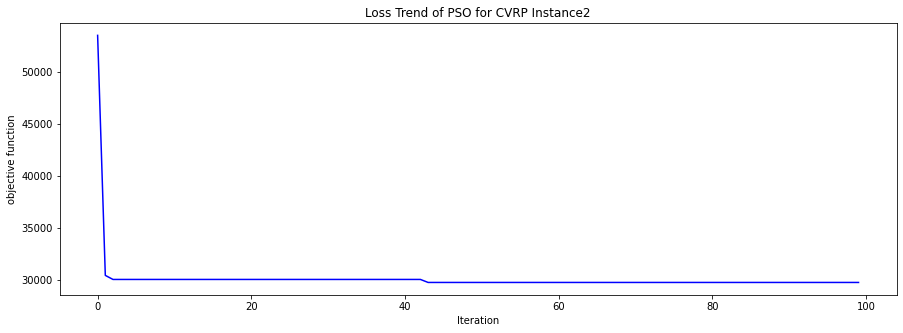

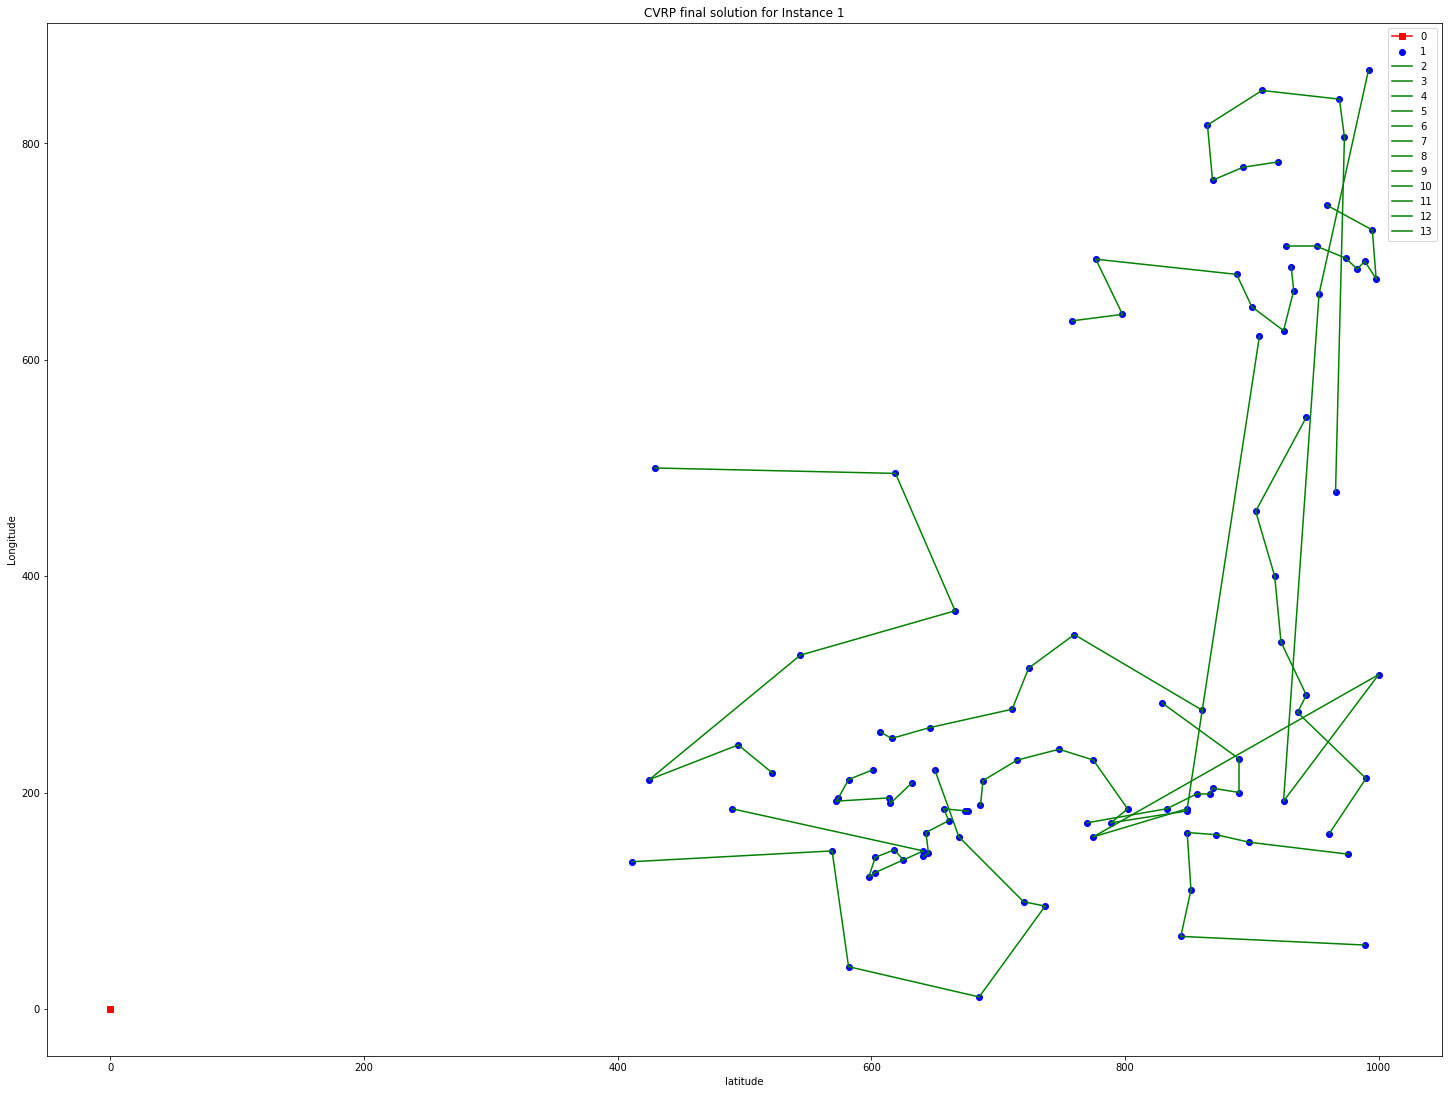

In [265]:
FIG = plt.figure(figsize=(15,5))
ax1 = FIG.add_subplot(111)
ax1.plot(Loss,'b')


ax1.set_title('Loss Trend of PSO for CVRP'+' Instance'+str(Instance))
ax1.set_ylabel('objective function')
ax1.set_xlabel('Iteration')
plt.savefig('loss function ACO 1')

comput_cost_counter = N_Particles*T_max
with open ('PSO_Instance1-1.txt','w') as f:
    f.write('NO. Of Instance: '+str(Instance)+'\n')
    f.write('Model Parameters: ' +str(Vel_Up_Param)+'\n')

    f.write('Size of Particles : '+str(N_Particles)+'\n')
    f.write('Number of Iteration: '+str(T_max)+'\n')
    f.write('Best Objective function: ' + str(Best_Objective_function)+'\n' )
    f.write('Gap: ' + str(GAP)+'%'+'\n' )
    f.writelines('CPU Time: '+str(CPU_TIME)+'\n')
    f.write('The total number of times that the objective function is evaluated: '+str(comput_cost_counter)+'\n')

    for row in BEST_ROUTE.keys():
        f.writelines('Route No.'+str(row)+': '+str(BEST_ROUTE[row])+'\n')

data_info = Data_Parameters['data_information']
df  = Data_Parameters['location']
clist  = Data_Parameters['customer_list']
arc  = Data_Parameters['coords']
x_d, y_d, x_c, y_c = coordinates(df, data_info)
arcs = [(int(i),int(j)) for i in clist for j in clist if i!=j]

graph1, X1 = active_graph(BEST_ROUTE, arc)
visible_node = [a for a in arcs if X1[a]>0]
plt.figure(figsize=(25,19))
ax = plt.subplot(111)
plt.plot(x_d, y_d, 'r',marker ='s')
plt.scatter(x_c, y_c,c='b', marker='o')
k=0
groups = BEST_ROUTE.keys()
for i,j in visible_node:
    plt.plot([df['x'][i], df['x'][j]],[df['y'][i], df['y'][j]],'g')

plt.title("CVRP final solution for Instance 1")
plt.ylabel("Longitude")
plt.xlabel("latitude")
plt.legend(groups)
plt.savefig('problem_ACO 1')